In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# imports
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp
from collections import defaultdict
from tqdm import tqdm

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights, compute_M_inv, compute_force_term, compute_W_with_IC
from src.utils_plot import plot_loss_and_all_solution, plot_transfer_learned_and_analytical
from src.load_save import load_run_history

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [7]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Tue Feb 13 10:23:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   33C    P8              N/A /  20W |    388MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
file_name = "final_inference_2121806"
equation_name = "linear_exemple1"

trained_model, \
x_range, \
iterations, \
hid_lay, \
num_equations, \
num_heads, \
loss_hist, \
alpha_list, \
A_list, \
v_list, \
force_list = load_run_history(equation_name, file_name, dev, prev=False)

force_list = [
    lambda t, alpha=a, omega=w: torch.vstack([2*torch.sin(omega*t), alpha*(torch.cos(omega*t)-torch.sin(omega*t))]).T.double()
    if not isinstance(t, (float, int))
    else np.array([2*np.sin(omega*t), alpha*(np.cos(omega*t)-np.sin(omega*t))]).T
    for a, w in zip(alpha_list, [2.36090035, 1.90842823, 2.59444808, 0.93323029, 1.204341])
]

Force change with time


In [9]:
# function to get A for alpha value and DHO equation
def get_A(alpha):
    return torch.tensor([[2., -1.], [1-alpha, alpha]], device=dev).double() 

# Numerical solution
def double_coupled_equation(t, y, A, force):
    return np.array([force(t)[..., 0].item()- A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[..., 1].item() - A[1][0] * y[0] - A[1][1] * y[1]])

r_tol = 1e-4
numerical_sol_fct_radau = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                  v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau", rtol=r_tol).y)

numerical_sol_fct_rk45 = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="RK45", rtol=r_tol).y)

numerical_sol_fct_lsoda = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="LSODA", rtol=r_tol).y)

numerical_methods = {"RK45": numerical_sol_fct_rk45, "Radau": numerical_sol_fct_radau}

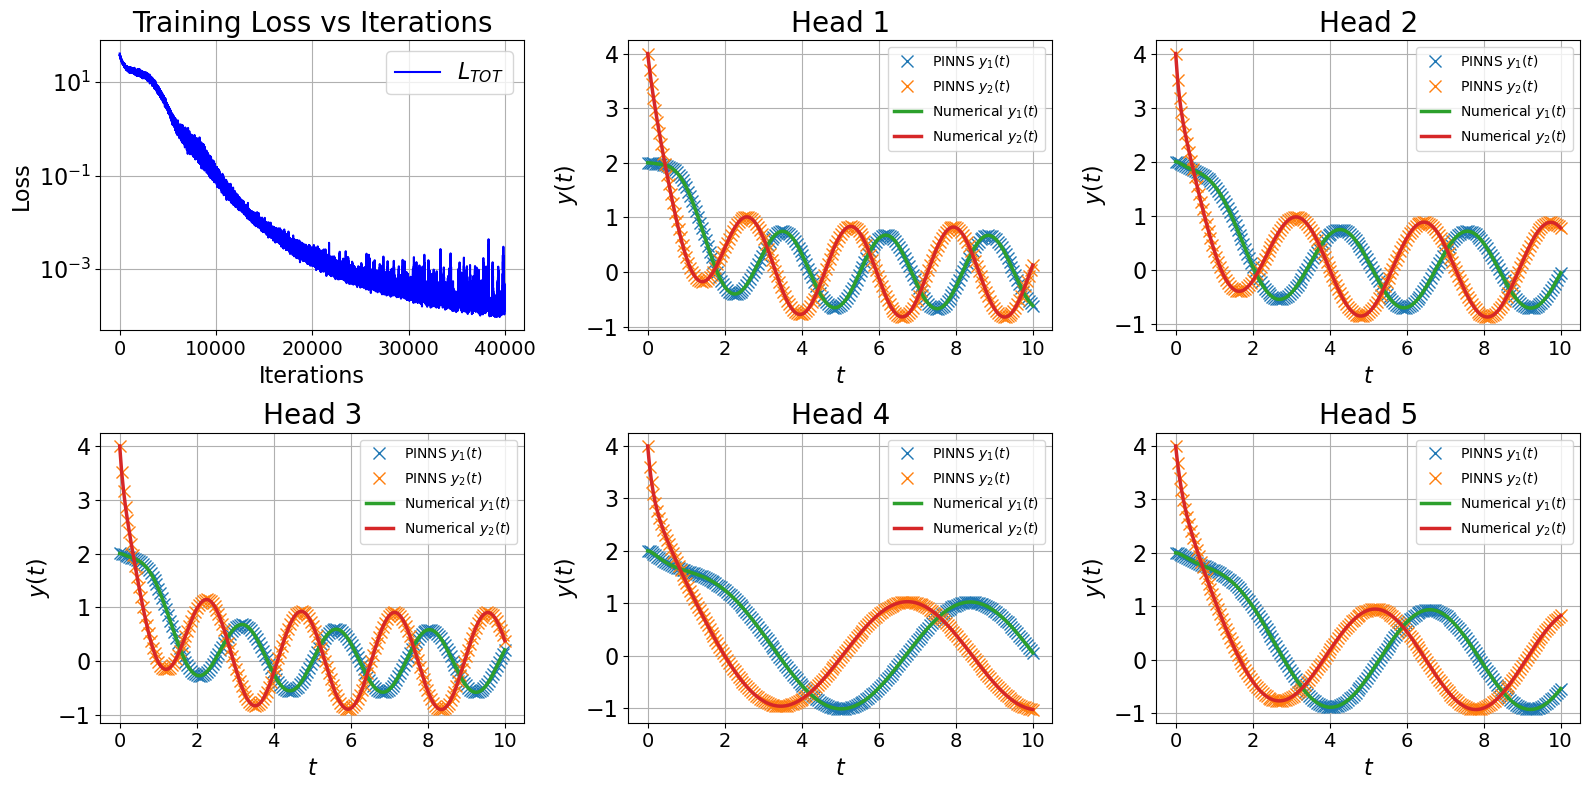

In [10]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct_radau,
                           trained_model=trained_model, v_list=v_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist, device=dev)

Time to compute H and dH_dt:  1.705 seconds
Time to compute weights (given H and dH_dt):  6.312 seconds
mean 0.008236585798679578
max 0.024637644152288474
mean 0.008717843856486995
max 0.02323700373896287


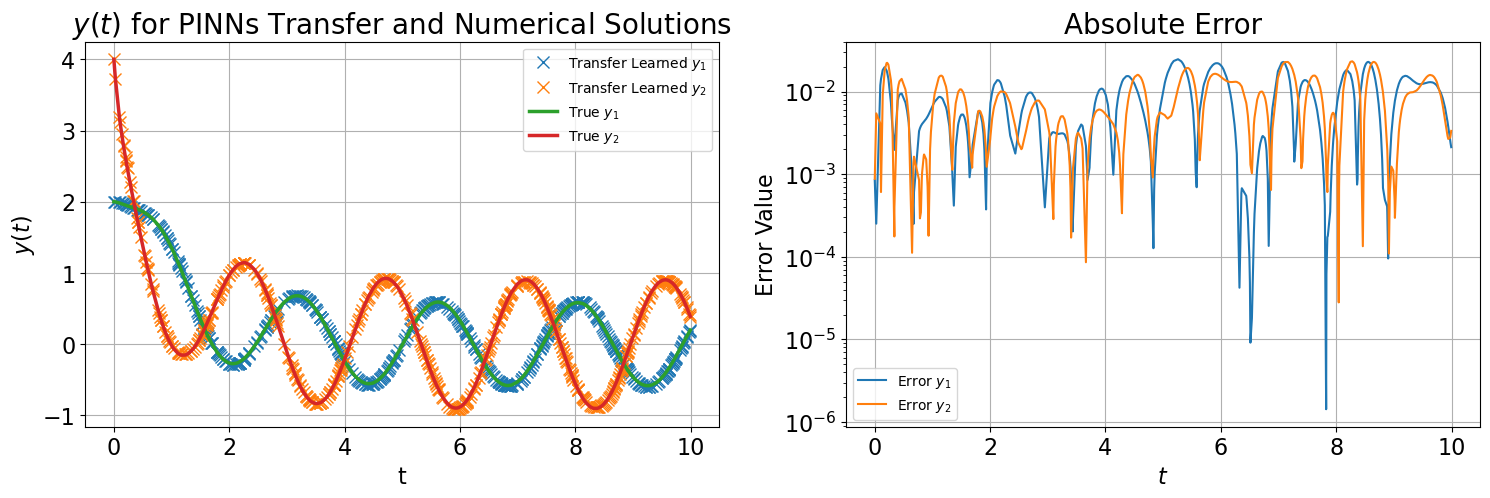

In [11]:
# forward pass to extract H
size = 512
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay, size, dev)

# choose an initial condition and set of coefficients that were trained on
v = v_list[2]
A = A_list[2]
force = force_list[2]
M_inv, W_out, force_terms, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                     v, A, force)
plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force,
                                     num_equations, numerical_sol_fct_radau)

Time to compute weights (given H and dH_dt):  0.047 seconds
mean 0.012101505768435869
max 0.05819576785461536
mean 0.011569383418595404
max 0.05268422211381729


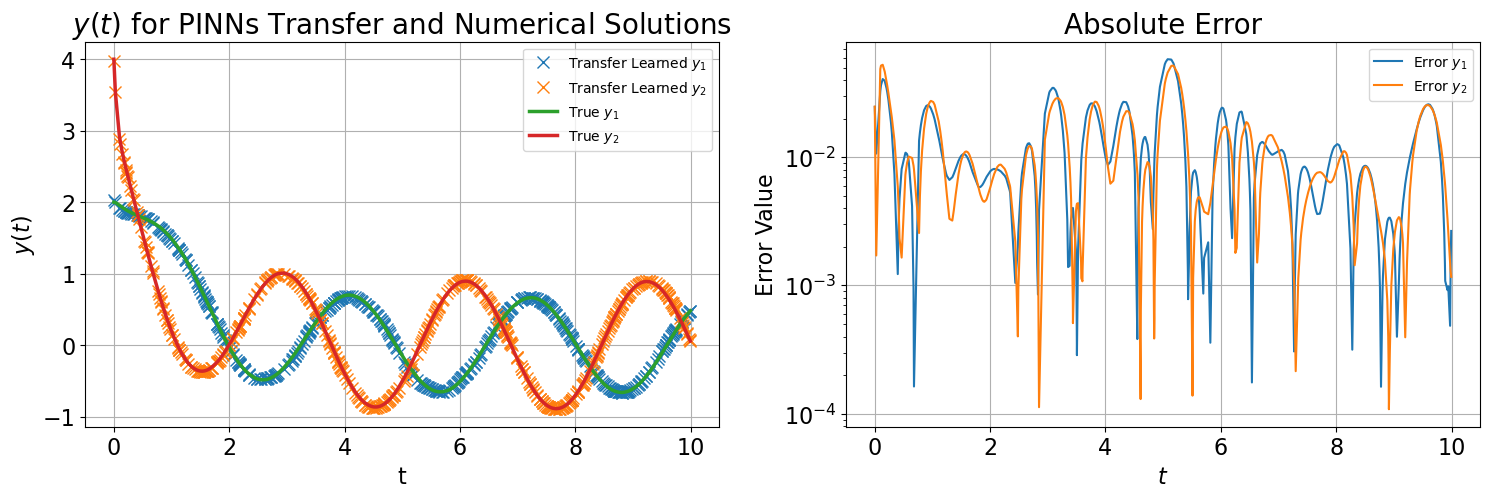

In [12]:
# stiff parameter alpha list
alpha_transfer = 20

transfer_A = get_A(alpha_transfer)
force_transfer =  lambda t, alpha=alpha_transfer, omega=2: torch.vstack([2*torch.sin(omega*t), alpha*(torch.cos(omega*t)-torch.sin(omega*t))]).T.double() \
                                                           if not isinstance(t, (float, int)) \
                                                           else np.array([2*np.sin(omega*t), alpha*(np.cos(omega*t)-np.sin(omega*t))]).T

IC_transfer = v_list[0]

omega_bounds = (0, np.pi)
def generate_omega(k, omega_bounds = omega_bounds):
  omega_list = np.zeros(k)
  for i in range(k):
    omega_list[i] = np.random.uniform(omega_bounds[0], omega_bounds[1])
  return omega_list
omega_list = generate_omega(num_heads)

# compute the transfer learned solution
M_inv_new, W_out_new_A, force_terms_new, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                       IC_transfer, transfer_A, force_transfer)
# plot the transfer learned and true solutions
plot_transfer_learned_and_analytical(H, W_out_new_A, t_eval, IC_transfer, transfer_A, force_transfer,
                                     num_equations, numerical_sol_fct_radau)

## Inference Analysis

Inference in machine learning involves using a trained model to find inputs that produce a desired output or prediction.

### 1. Change IC in a stiff regime
### 2. Change force in a stiff regime
### 3. Change IC and force in a stiff regime


In [13]:
change_IC = False
change_force = True

In [19]:
alpha_transfer = 1000
A_transfer = get_A(alpha=alpha_transfer)
A_transfer = A_transfer.double()
dH_dt_new = dH_dt_new.double()
H = H.double()
H_0 = H_0.double()

M_inv = compute_M_inv(dH_dt_new, H, H_0, t_eval, A_transfer)

if not change_force:
    force_terms = compute_force_term(t_eval, A_transfer, force, H, dH_dt_new)

if not change_IC:
    IC_term = torch.matmul(H_0.T, v)

In [20]:
np.random.seed(42)
nb_transfer_equation = 100

IC_transfer_list = [v for _ in range(nb_transfer_equation)]

force_transfer_list = [lambda t, alpha=alpha_transfer, omega=generate_omega(k=1).item(): torch.vstack([2*torch.sin(omega*t), alpha*(torch.cos(omega*t)-torch.sin(omega*t))]).T.double() \
                                                           if not isinstance(t, (float, int)) \
                                                           else np.array([2*np.sin(omega*t), alpha*(np.cos(omega*t)-np.sin(omega*t))]).T for _ in range(nb_transfer_equation)]

computational_time = defaultdict(list)
max_error = defaultdict(list)
mean_error = defaultdict(list)
solution = defaultdict(list)

for IC_transfer, force_transfer in tqdm(zip(IC_transfer_list, force_transfer_list), total=nb_transfer_equation):
    # PINNS (change only IC)
    if (change_IC) & (~change_force):
        start = time.time()
        W_out, _ = compute_W_with_IC(M_inv, force_terms, IC_transfer, H_0)
        pinns_sol = torch.matmul(H, W_out)
        end = time.time()
    
    # PINNS (change only force)
    elif (change_force) & (~change_IC):
        start = time.time()
        force_terms = compute_force_term(t_eval, A_transfer, force_transfer, H, dH_dt_new)
        rhs_terms = force_terms + IC_term
        W_out = torch.matmul(M_inv, rhs_terms)
        pinns_sol = torch.matmul(H, W_out)
        end = time.time()

    # PINNS (change IC and force)
    elif (change_force) & (change_IC):
        start = time.time()
        force_terms = compute_force_term(t_eval, A_transfer, force_transfer, H, dH_dt_new)
        W_out, _ = compute_W_with_IC(M_inv, force_terms, IC_transfer, H_0)
        pinns_sol = torch.matmul(H, W_out)
        end = time.time()

    solution["PINNS"].append(np.swapaxes(pinns_sol.detach().cpu().numpy().squeeze(), 0, 1))
    computational_time["PINNS"].append(end-start)

    # solve with numerical methods
    for method, fct in numerical_methods.items():
        start = time.time()
        numerical_sol = fct(t_eval.detach().cpu().numpy(), IC_transfer.detach().cpu(),
                            A_transfer.cpu(),
                            force_transfer)
        solution[method].append(numerical_sol)
        end = time.time()
        computational_time[method].append(end-start)

    # # get error
    # max_error["PINNS"].append([]); 
    # mean_error["PINNS"].append([]); 
    # for method in numerical_methods.keys():
    #     max_error[method].append([])
    #     mean_error[method].append([])
    # for i in range(num_equations):
    #   # pinns error
    #   predicted_vals = pinns_sol[:, i, :].detach().cpu().numpy().squeeze()
    #   pinns_erros = np.abs(predicted_vals - true_solution[i, :])
    #   max_error["PINNS"][-1].append(pinns_erros.max())
    #   mean_error["PINNS"][-1].append(pinns_erros.mean())
    #   # Numerical error
    #   for method in numerical_methods.keys():
    #     sol = solution[method]
    #     numerical_error = np.abs(sol[-1][i] - true_solution[i])
    #     max_error[method][-1].append(numerical_error.max())
    #     mean_error[method][-1].append(numerical_error.mean())

100%|██████████| 100/100 [06:35<00:00,  3.95s/it]


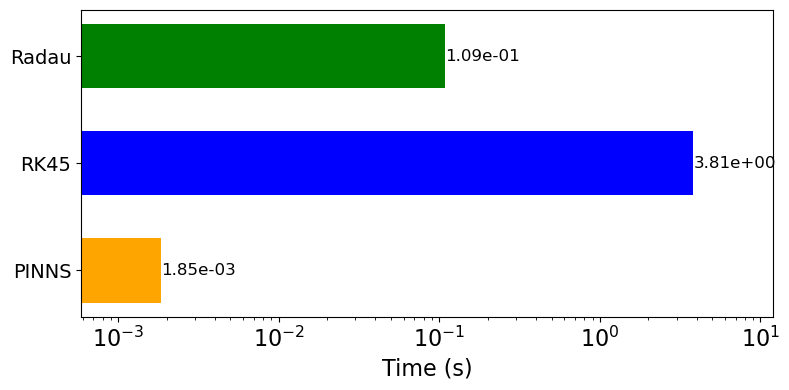

In [21]:
import matplotlib.pyplot as plt

color = {"PINNS": 'orange', "RK45": 'b', "Radau": 'g', 'LSODA': 'm', "True": (1, 0, 0, 0.5)}
fig, ax = plt.subplots(1, tight_layout=True, figsize=(8, 4))

height = 0.6  # Change width to height for horizontal bars

for i, (method, compt_time) in enumerate(computational_time.items()):
    ax.barh(i, sum(compt_time)/len(compt_time), height=height, color=color[method], label=f"{method}")
    ax.annotate(f'{sum(compt_time)/len(compt_time):1.2e}', (sum(compt_time)/len(compt_time), i),
                ha='left', va='center', fontsize=12)  # Adjusted annotation placement for horizontal bars

ax.set_xscale("log")  # Change yscale to xscale for horizontal bars
change_title = "IC and force" if (change_force and change_IC) else ("force" if change_force else "IC")
#ax.set_title(rf"Average Time Solving {nb_transfer_equation} stiff equations $\alpha$={alpha_transfer} by changing {change_title}", fontsize=20)
ax.set_xlabel('Time (s)', fontsize=16)  # Change ylabel to xlabel for horizontal bars
ax.set_yticks([i for i in range(len(computational_time))])
ax.set_yticklabels(computational_time.keys())  # Change xticks to yticks and set_xticks to set_yticks
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=16)
fig.tight_layout()
ax.margins(x=0.15)


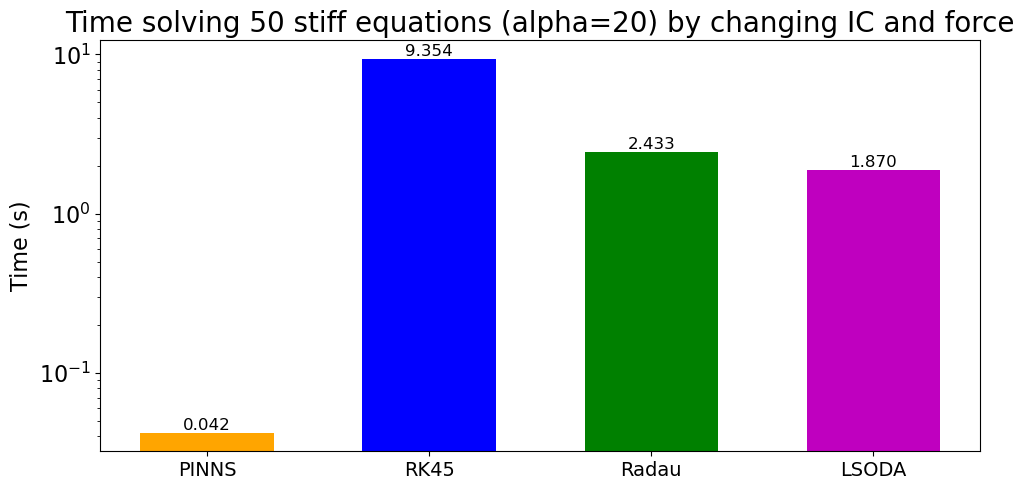

In [14]:
color = {"PINNS": 'orange', "RK45": 'b', "Radau": 'g', 'LSODA': 'm', "True": (1, 0, 0, 0.5)}
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 5))

width = 0.6

for i, (method, compt_time) in enumerate(computational_time.items()):
    ax.bar(i, sum(compt_time), width=width, color=color[method],  label=f"{method} ")
    ax.annotate(f'{sum(compt_time):0.3f}', (i, sum(compt_time)), ha='center', va='bottom', fontsize=12)
ax.set_yscale("log")
change_title = "IC and force" if (change_force and change_IC) else ("force" if change_force else "IC")
ax.set_title(f"Time solving {nb_transfer_equation} stiff equations (alpha={alpha_transfer}) by changing {change_title}", fontsize=20)
ax.set_ylabel('Time (s)', fontsize=16)
ax.set_xticks([i for i in range(len(computational_time))], computational_time.keys())
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Mean Absolute Error solving Stiff Equation by changing force')

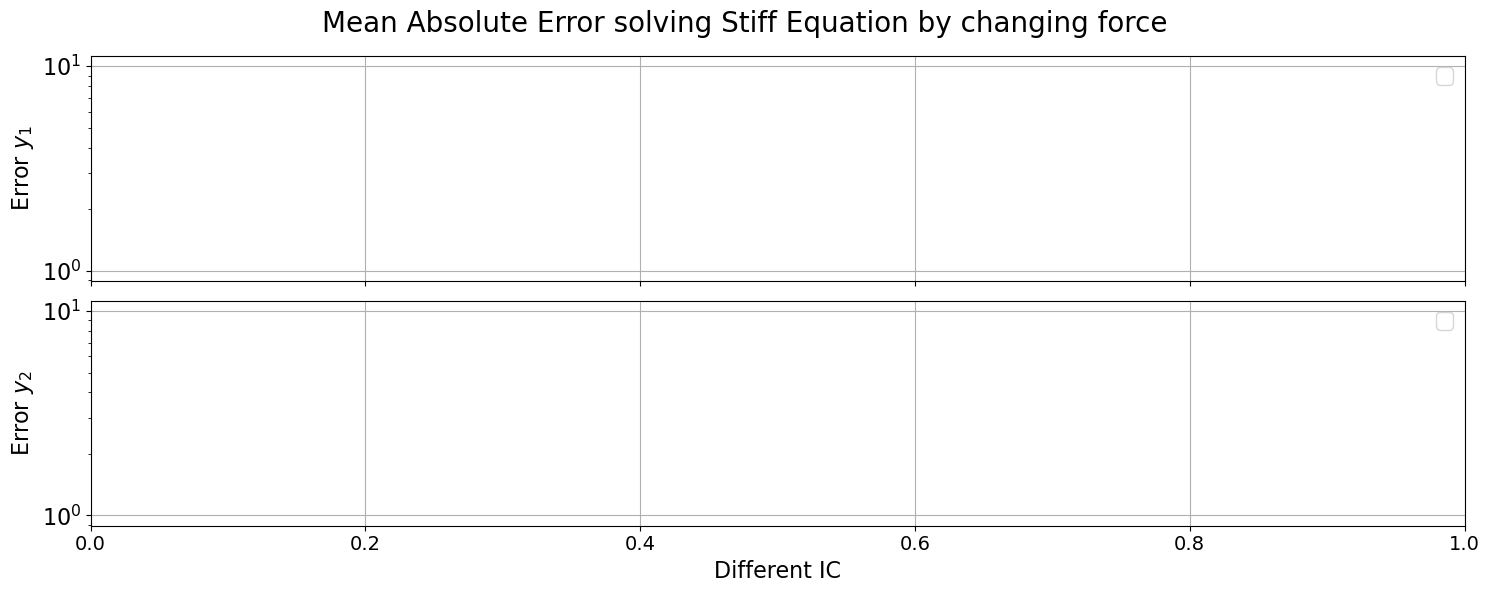

In [13]:
fig, ax = plt.subplots(2, tight_layout=True, figsize=(15, 6), sharex=True)
for method, mean in mean_error.items():
        ax[0].plot(np.array(mean)[:, 0], '-o', color=color[method], label=f"{method}")
        ax[1].plot(np.array(mean)[:, 1], '-o', color=color[method], label=f"{method}")

ax[0].set_yscale("log")
ax[0].set_ylabel('Error $y_1$', fontsize=16)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=16)
ax[0].legend(loc='best', fontsize=16)
ax[0].grid()

ax[1].set_yscale("log")
ax[1].set_xlabel('Different IC', fontsize=16)
ax[1].set_ylabel('Error $y_2$', fontsize=16)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=16)
ax[1].legend(loc='best', fontsize=16)
ax[1].grid()

change_title = "IC and force" if (change_force and change_IC) else ("force" if change_force else "IC")
fig.suptitle(f"Mean Absolute Error solving Stiff Equation by changing {change_title}", fontsize=20)

Text(0.5, 0.98, 'Max Absolute Error solving Stiff Equation by changing IC')

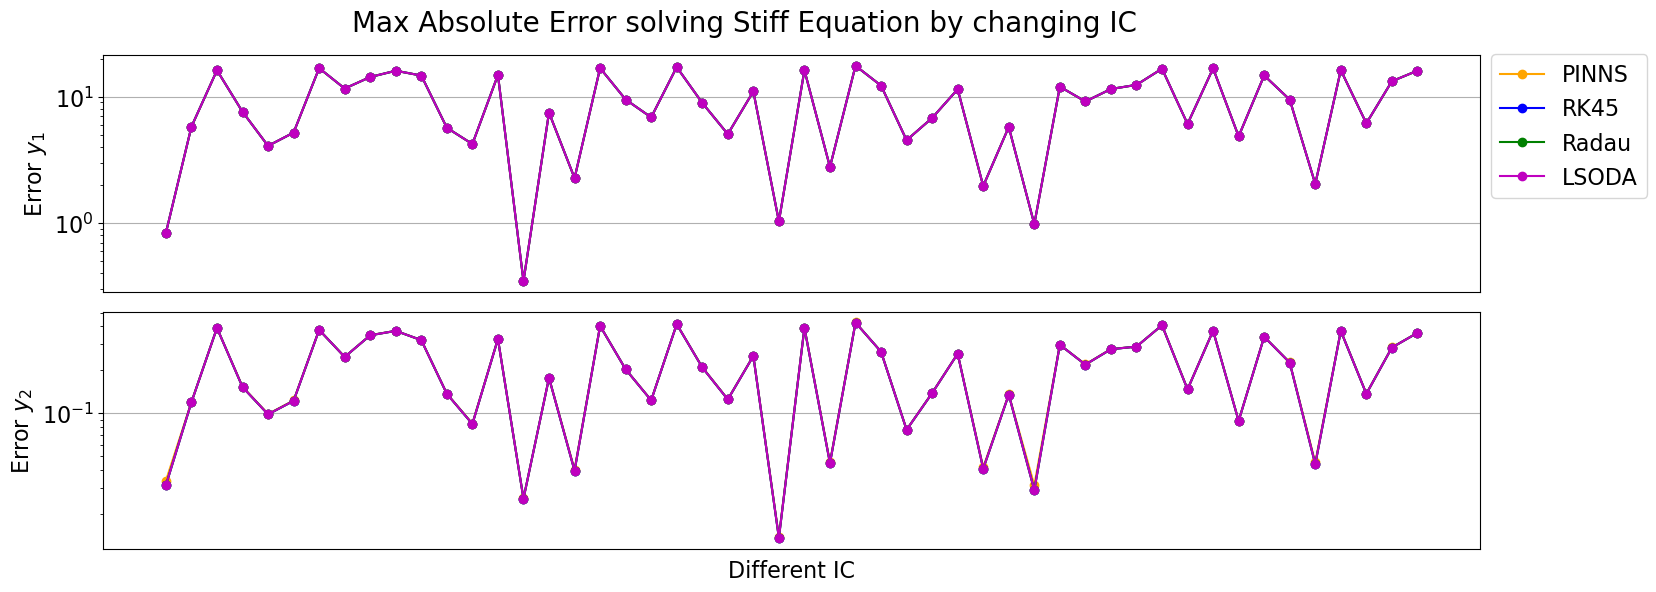

In [16]:
fig, ax = plt.subplots(2, tight_layout=True, figsize=(15, 6), sharex=True)
for method, max in max_error.items():
    ax[0].plot(np.array(max)[:, 0], '-o', color=color[method], label=f"{method}")
    ax[1].plot(np.array(max)[:, 1], '-o', color=color[method])

ax[0].set_yscale("log")
ax[0].set_ylabel('Error $y_1$', fontsize=16)
ax[0].tick_params(axis='y', labelsize=16)
ax[0].set_xticks([])
ax[0].grid()

ax[1].set_yscale("log")
ax[1].set_xlabel('Different IC', fontsize=16)
ax[1].set_ylabel('Error $y_2$', fontsize=16)
ax[1].tick_params(axis='y', labelsize=16)
ax[1].set_xticks([])
ax[1].grid()
fig.legend(fontsize=16, bbox_to_anchor=(0.99, 0.785), loc='center left')

fig.suptitle("Max Absolute Error solving Stiff Equation by changing IC", fontsize=20)